# Credit Card Fraud Detection

## Imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Normalization, Dense, Normalization
from tensorflow.keras.metrics import Recall, Precision, Accuracy, AUC
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
# url = "https://wagon-public-datasets.s3.amazonaws.com/Machine%20Learning%20Datasets/creditcard.csv"
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
X = df.drop(columns=["Class"], axis=1).values
y = df["Class"].values

## 1. Rebalancing classes

In [4]:
# Let's check class balance
pd.Series(y).value_counts(normalize=True)

0    0.998273
1    0.001727
Name: proportion, dtype: float64

In [5]:
# Train test split before any resampling to keep real test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3)

In [7]:
print(f'X_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')
print(f'X_val.shape = {X_val.shape}')
print(f'y_val.shape = {y_val.shape}')
print(f'X_test.shape = {X_test.shape}')
print(f'y_test.shape = {y_test.shape}')

X_train.shape = (139554, 30)
y_train.shape = (139554,)
X_val.shape = (59810, 30)
y_val.shape = (59810,)
X_test.shape = (85443, 30)
y_test.shape = (85443,)


In [8]:
print(np.sum(y_train[y_train == 1]))
print(np.sum(y_val[y_val == 1]))
print(np.sum(y_test[y_test == 1]))
print('-'*100)
print(f'There are {pd.Series(y_train).value_counts()[1]} fraudulent transactions in the train set')
print(f'There are {pd.Series(y_val).value_counts()[1]} fraudulent transactions in the val set')
print(f'There are {pd.Series(y_test).value_counts()[1]} fraudulent transactions in the test set')

244
106
142
----------------------------------------------------------------------------------------------------
There are 244 fraudulent transactions in the train set
There are 106 fraudulent transactions in the val set
There are 142 fraudulent transactions in the test set


In [9]:
#Sampling strategy
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.8)

In [10]:
steps = [('o', over), ('u' , under)]
pipeline = Pipeline(steps)
pipeline

Pipeline(steps=[('o', SMOTE(sampling_strategy=0.2)),
                ('u', RandomUnderSampler(sampling_strategy=0.8))])

In [11]:
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)
print(f'X_train_resampled.shape = {X_train_resampled.shape}')
print(f'y_train_resampled.shape = {y_train_resampled.shape}')

X_train_resampled.shape = (62689, 30)
y_train_resampled.shape = (62689,)


In [12]:
# pd.Series(y_train_resampled).value_counts(normalize=True)

In [13]:
stacked_resampled_data = np.hstack([X_train_resampled, y_train_resampled.reshape(-1, 1)])
np.random.shuffle(stacked_resampled_data)

In [14]:
X_train_resampled = stacked_resampled_data[:, :30]
y_train_resampled = stacked_resampled_data[:,-1]

## 2. Neural Network iterations

In [15]:
def initialize_model():
    # Normalization
    normalizer = Normalization()
    normalizer.adapt(X_train_resampled)
    
    # Model Architecture
    model = Sequential()
    model.add(normalizer)
    model.add(Dense(32, activation='relu', input_dim=X_train_resampled.shape[1:]))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(8,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    
    # Metrics
    metrics = [
        Recall(name='recall'),
        Precision(name='precision'),
        AUC(name='prc',curve='PR')
    ]
    # Model Compilation
    model.compile(
        optimizer=Adam(lr=0.0001),
        loss='binary_crossentropy',
        metrics=metrics
    )
    return model

In [16]:
model = initialize_model()

In [17]:
# EarlyStoping strategy 
es = EarlyStopping(
    patience=10,
    monitor='val_recall',
    restore_best_weights=True
)
# Training model
history = model.fit(
    X_train_resampled,
    y_train_resampled,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[es],
    shuffle=True,
)

Epoch 1/100



980/980 [==============================] - 11s 7ms/step - loss: 0.2145 - recall: 0.8840 - precision: 0.9208 - prc: 0.9703 - val_loss: 0.0379 - val_recall: 0.9434 - val_precision: 0.1631 - val_prc: 0.7313
Epoch 2/100
980/980 [==============================] - 5s 5ms/step - loss: 0.0942 - recall: 0.9567 - precision: 0.9779 - prc: 0.9931 - val_loss: 0.0378 - val_recall: 0.9434 - val_precision: 0.1302 - val_prc: 0.7433
Epoch 3/100
980/980 [==============================] - 5s 5ms/step - loss: 0.0716 - recall: 0.9711 - precision: 0.9815 - prc: 0.9960 - val_loss: 0.0286 - val_recall: 0.9340 - val_precision: 0.1569 - val_prc: 0.7571
Epoch 4/100
980/980 [==============================] - 5s 5ms/step - loss: 0.0590 - recall: 0.9783 - precision: 0.9827 - prc: 0.9972 - val_loss: 0.0217 - val_recall: 0.9434 - val_precision: 0.2037 - val_prc: 0.7705
Epoch 5/100
980/980 [==============================] - 5s 5ms/step - loss: 0.0487 - recall: 0.9834 - precision: 0.9854 - prc: 0.9976 - val_loss: 0.0215

980/980 [==============================] - 5s 5ms/step - loss: 0.0211 - recall: 0.9930 - precision: 0.9949 - prc: 0.9989 - val_loss: 0.0102 - val_recall: 0.8962 - val_precision: 0.5828 - val_prc: 0.7787


In [18]:
def plot_loss_precision_recall_curve(history):
    
    fig, ax =plt.subplots(1, 3, figsize=(20, 5))
    
    # --- LOSS
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'], loc='upper right')
    ax[0].grid(axis="x", linewidth=0.5)
    ax[0].grid(axis="y", linewidth=0.5)
    
    # --- RECALL
    ax[1].plot(history.history['recall'])
    ax[1].plot(history.history['val_recall'])
    ax[1].set_title('Model recall', fontsize = 18)
    ax[1].set_xlabel('Epoch', fontsize = 14)
    ax[1].set_ylabel('Recall', fontsize = 14)
    ax[1].legend(['Train', 'Val'], loc='lower right') 
    ax[1].grid(axis="x", linewidth=0.5)
    ax[1].grid(axis="y", linewidth=0.5)
    
    # --- PRECISION
    ax[2].plot(history.history['precision'])
    ax[2].plot(history.history['val_precision'])
    ax[2].set_title('Model precision', fontsize = 18)
    ax[2].set_xlabel('Epoch', fontsize = 14)
    ax[2].set_ylabel('Precision', fontsize = 14)
    ax[2].legend(['Train', 'Val'], loc='lower right')  
    ax[2].grid(axis="x", linewidth=0.5)
    ax[2].grid(axis="y", linewidth=0.5)    

    plt.show();

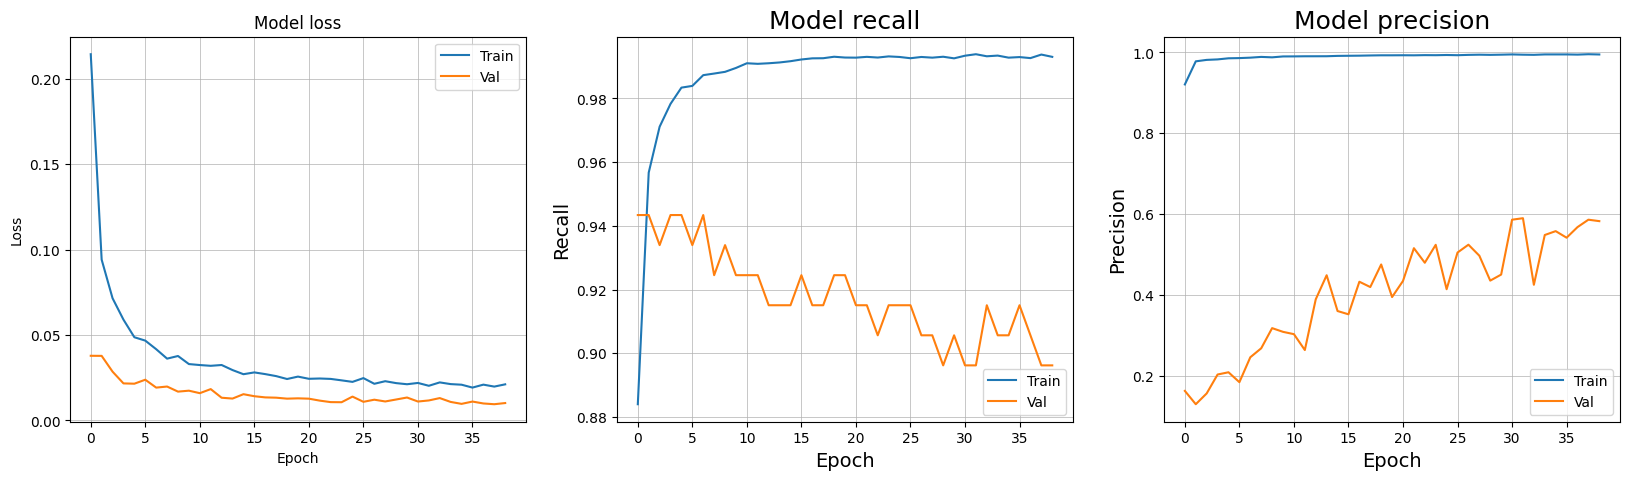

In [19]:
plot_loss_precision_recall_curve(history)

In [20]:
model.evaluate(X_test, y_test ,return_dict=True)

2671/2671 [==============================] - 5s 2ms/step - loss: 0.0143 - recall: 0.8521 - precision: 0.3967 - prc: 0.6903


{'loss': 0.014305033721029758,
 'recall': 0.8521126508712769,
 'precision': 0.3967213034629822,
 'prc': 0.6902826428413391}

In [21]:
y_pred_proba = model.predict(X_test)

2671/2671 [==============================] - 5s 2ms/step


In [22]:
treshold = 0.5
y_pred_binary = np.where(y_pred_proba > treshold, 1, 0)

In [23]:
cm = confusion_matrix(y_test, y_pred_binary)

Text(0.5, 25.722222222222214, 'Predicted label')

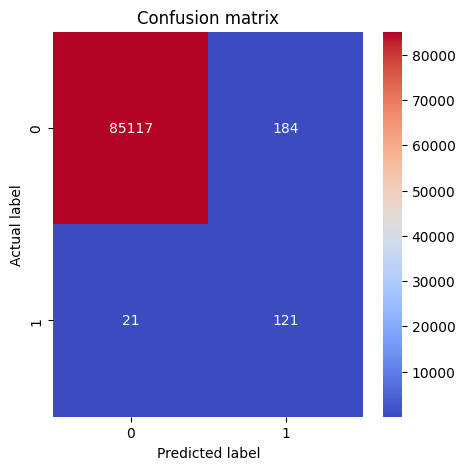

In [24]:
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d",cmap='coolwarm')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [25]:
print(classification_report(y_test,y_pred_binary))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85301
           1       0.40      0.85      0.54       142

    accuracy                           1.00     85443
   macro avg       0.70      0.92      0.77     85443
weighted avg       1.00      1.00      1.00     85443



In [26]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)
    plt.plot(recall, precision, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

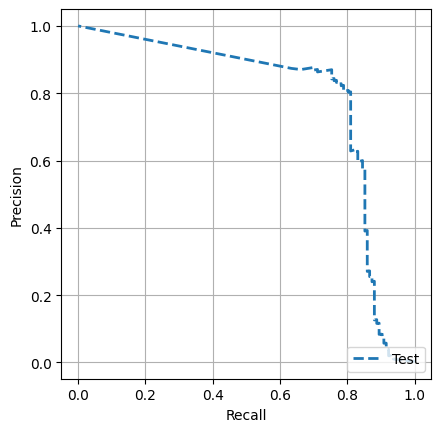

In [27]:
plot_prc('Test', y_test, y_pred_proba, linestyle='--')
plt.legend(loc='lower right');